In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize, signal
from sklearn import metrics
from sklearn.linear_model import LinearRegression

$$\mathrm{A \underset{Ni}{\overset{k_1}{\longrightarrow}} B + C}$$

$$r = k_1 \theta_A = k_1\frac{aA}{1 + aA + bB + cC}$$

$$r = \frac{1}{V}\frac{\mathrm{d}\xi}{\mathrm{d}t} \simeq k_1\frac{aA}{aA + bB} = k\frac{a(n_0 - \xi)}{a(n_0 - \xi) + b\xi}$$

$$\int\limits_0^\xi\left(1 + \frac{b\xi}{a(n_0-\xi)}\right)\mathrm{d}\xi = \int\limits_0^t k_1V\mathrm{d}t$$

$$\left(1 - \frac{b}{a}\right)\xi - n_0\frac{b}{a}\ln\left|\frac{n_0 - \xi}{n_0}\right| = k_1Vt$$

$$ t(\xi) = \frac{1}{k_1}(1-k_2) \frac{\xi}{V} + \frac{k_2}{k_1}\left(-\frac{n_0}{V}\right)\ln\left|\frac{n_0 - \xi}{n_0}\right| = c_1 x_1(\xi) + c_2 x_2(\xi)$$

$$k_1 = \frac{1}{c_1 + c_2} \,,\quad k_2 = \frac{c_2}{c_1 + c_2}$$

$$r = k_1\frac{aA}{aA + bB} \rightarrow \frac{1}{r} = \frac{1}{k_1}\left(1 + k_2 \frac{\xi}{n_0 - \xi}\right) $$

In [2]:
df = pd.read_excel("cathet.xlsx")

In [3]:
df = df.loc[2:]

In [4]:
df["t"] = df["t"] - df.loc[2, "t"]
df["V"] = df["V"] - df.loc[2, "V"]

In [5]:
df[:5]

,t,V
2,0,0.000000
3,39,0.000008
4,131,0.000027
5,184,0.000038
6,214,0.000044


In [6]:
df.to_csv("cathet.csv", index=False)

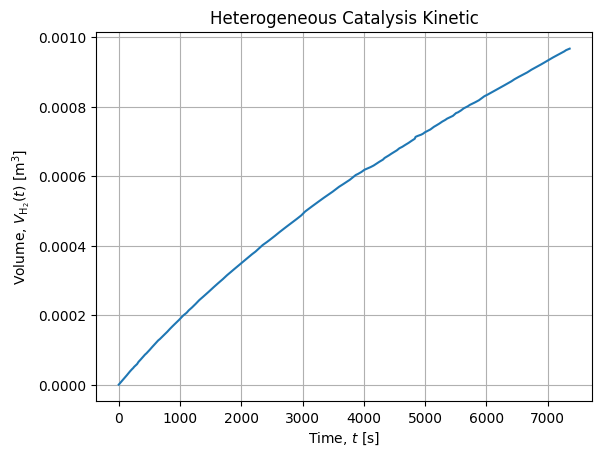

In [7]:
fig, axe = plt.subplots()
axe.plot(df["t"], df["V"])
axe.set_title("Heterogeneous Catalysis Kinetic")
axe.set_xlabel("Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel("Volume, $V_\mathrm{H_2}(t)$ $[\mathrm{m^3}]$")
axe.grid()

In [8]:
R = 8.31446261815324  # J/mol.K
T0 = 292.05           # K
p0 = 101600           # Pa
V = 190e-6            # m3 of isopropanol
m = 2.7677            # g of Raney Nickel
rho = 785             # kg/m³
M = 60.1              # g/mol
n0 = 1000*rho*V/M     # mol

In [9]:
n0

2.4816971713810316

In [10]:
df["xi"] = p0*df["V"]/(R*T0)
df["B/A"] = df["xi"]/(n0 - df["xi"])
df["x1"] = df["xi"]/V
df["x2"] = -(n0/V)*np.log(np.abs((n0 - df["xi"])/n0))
df["dxidt1"] = df["xi"].diff()/df["t"].diff()
df["1/r1"] = V/df["dxidt1"]

In [11]:
df.sample(5)

,t,V,xi,B/A,x1,x2,dxidt1,1/r1
96,5537,0.000785,0.032824,0.013404,172.759389,173.912069,0.000003,65.153446
35,1622,0.000292,0.012226,0.004951,64.347092,64.506115,0.000007,28.897259
116,7300,0.000964,0.040314,0.016513,212.178039,213.920291,0.000005,37.396452
27,1108,0.000207,0.008665,0.003504,45.606717,45.686525,0.000006,31.732274
48,2551,0.000429,0.017946,0.007284,94.450608,94.793758,0.000006,33.058464


In [12]:
results = {}

## OLS

In [13]:
XOLS = df[["x1", "x2"]].values
yOLS = df["t"].values

In [14]:
OLS = LinearRegression(fit_intercept=False).fit(XOLS, yOLS)
scoreOLS = OLS.score(XOLS, yOLS)
scoreOLS

0.9999526276968934

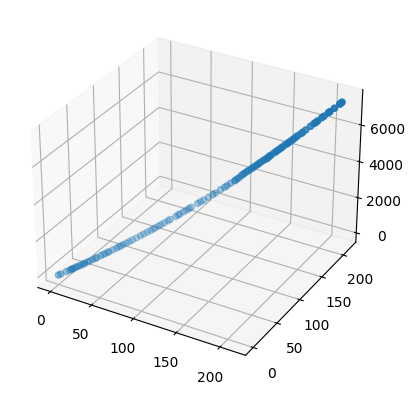

In [15]:
fig = plt.figure()
axe = fig.add_subplot(projection='3d')
axe.scatter(XOLS[:,0], XOLS[:,1], yOLS)

In [16]:
OLS.coef_

array([-1619.94014191,  1640.97679807])

In [17]:
OLS.intercept_

0.0

In [18]:
tOLS = OLS.predict(XOLS)

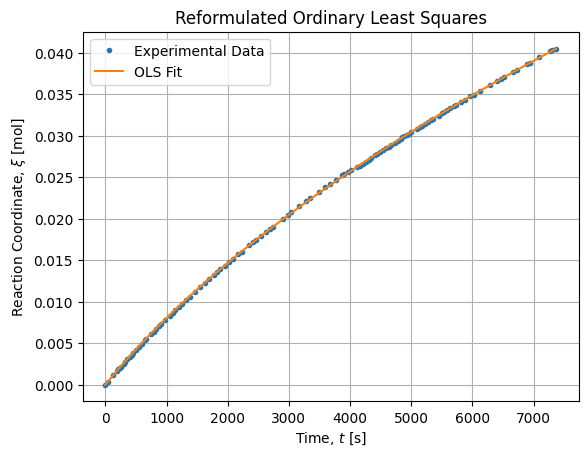

In [19]:
fig, axe = plt.subplots()
axe.plot(df["t"], df["xi"], ".", label="Experimental Data")
axe.plot(tOLS, df["xi"], "-", label="OLS Fit")
axe.set_title("Reformulated Ordinary Least Squares")
axe.set_xlabel("Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Reaction Coordinate, $\xi$ $[\mathrm{mol}]$")
axe.legend()
axe.grid()

In [20]:
def solveOLS(c1, c2):
    k1 = 1./(c1 + c2)
    k2 = c2*k1
    return k1, k2

In [21]:
k1OLS, k2OLS = solveOLS(*OLS.coef_)
k1OLS, k2OLS

(0.04753607191540943, 78.00559108463023)

In [22]:
k1OLS*V/m # mol/s

3.2633065953419057e-06

In [23]:
results["OLS"] = {
    "k1": k1OLS, "k2": k2OLS,
    "MSE": metrics.mean_squared_error(yOLS, tOLS),
    "r2": metrics.r2_score(yOLS, tOLS)
}
results["OLS"]

{'k1': 0.04753607191540943,
 'k2': 78.00559108463023,
 'MSE': 220.70733391613194,
 'r2': 0.9999526276968934}

## Lineweaver-Burk

In [24]:
XLB = df[["B/A"]].values[1:]
yLB = df["1/r1"].values[1:]
LB = LinearRegression(fit_intercept=True).fit(XLB, yLB)
LB.score(XLB, yLB)

0.565121006848629

In [25]:
LB.coef_, LB.intercept_

(array([1664.13293139]), 21.268198300365704)

In [26]:
XLBmax = np.linspace(df["B/A"].min(), df["B/A"].max(), 2).reshape(-1, 1)
yLBhat = LB.predict(XLB)

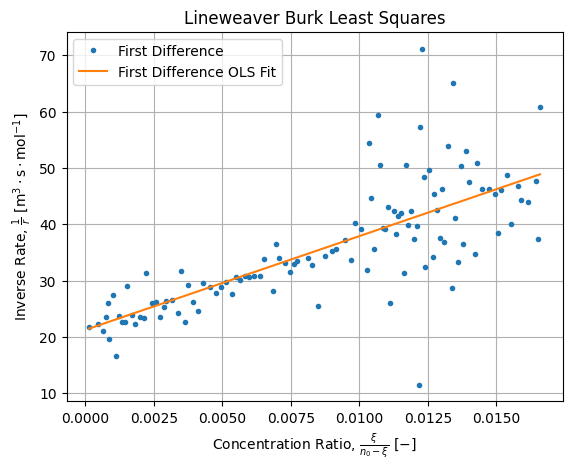

In [27]:
fig, axe = plt.subplots()
axe.plot(df["B/A"], df["1/r1"], ".", label="First Difference")
axe.plot(XLB, yLBhat, label="First Difference OLS Fit")
axe.set_title("Lineweaver Burk Least Squares")
axe.set_xlabel(r"Concentration Ratio, $\frac{\xi}{n_0 - \xi}$ $[-]$")
axe.set_ylabel(r"Inverse Rate, $\frac{1}{r}$ $[\mathrm{m^3\cdot s \cdot mol^{-1}]}$")
axe.legend()
axe.grid()

In [28]:
k1LB = 1/LB.intercept_
k2LB = LB.coef_[0]*k1LB
k1LB, k2LB

(0.04701855727867674, 78.2451295537145)

In [29]:
results["LB"] = {
    "k1": k1LB, "k2": k2LB,
    "MSE": metrics.mean_squared_error(yLB, yLBhat),
    "r2": metrics.r2_score(yLB, yLBhat)
}
results["LB"]

{'k1': 0.04701855727867674,
 'k2': 78.2451295537145,
 'MSE': 49.8171431042655,
 'r2': 0.565121006848629}

### LMA

In [30]:
def factory(n0, V):
    def wrapped(xi, k1, k2):
        return (1-k2)/k1*(xi/V) - (k2/k1)*(n0/V)*np.log((n0 - xi)/n0)
    return wrapped

In [31]:
objective = factory(n0, V)

In [32]:
parameters, covariance = optimize.curve_fit(objective, df["xi"], df["t"])
parameters, covariance

(array([4.75360716e-02, 7.80055896e+01]),
 array([[1.21265292e-08, 5.87172563e-05],
        [5.87172563e-05, 2.90824476e-01]]))

In [33]:
that = objective(df["xi"], *parameters)

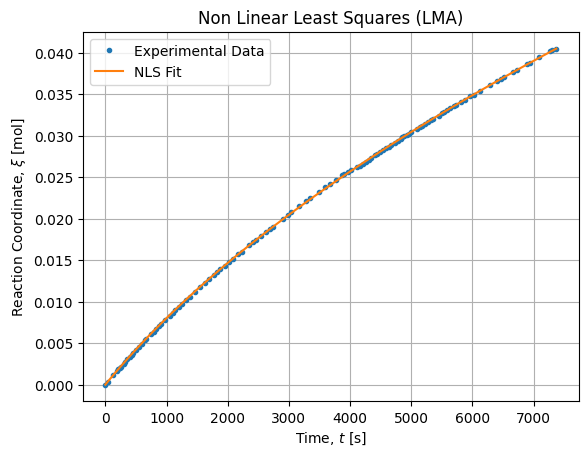

In [34]:
fig, axe = plt.subplots()
axe.plot(df["t"], df["xi"], ".", label="Experimental Data")
axe.plot(that, df["xi"], "-", label="NLS Fit")
axe.set_title("Non Linear Least Squares (LMA)")
axe.set_xlabel("Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Reaction Coordinate, $\xi$ $[\mathrm{mol}]$")
axe.legend()
axe.grid()

In [35]:
results["LMA"] = {
    "k1": parameters[0], "k2": parameters[1],
    "MSE": metrics.mean_squared_error(df["t"], that),
    "r2": metrics.r2_score(df["t"], that)
}
results["LMA"]

{'k1': 0.04753607161313695,
 'k2': 78.00558959396061,
 'MSE': 220.70733391605376,
 'r2': 0.9999526276968934}

## LBP3

In [36]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

XP3 = df["t"].values.reshape(-1, 1)
yP3 = df["xi"].values

#XP3f = preprocessing.PolynomialFeatures(degree=4).fit_transform(XP3)
#P3 = LinearRegression(fit_intercept=True).fit(XP3f, yP3)
#P3.score(XP3f, yP3)

pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('polynomial', PolynomialFeatures(5)),
    ('ols', TransformedTargetRegressor(
        LinearRegression(fit_intercept=False), transformer=MinMaxScaler()
    ))
])

pipe.fit(XP3, yP3)
print(pipe.score(XP3, yP3))

0.9999769561903573


In [37]:
#yP3hat = P3.predict(XP3f)
yP3hat = pipe.predict(XP3)
dCdt = np.diff(yP3hat)/df["t"].diff().values[1:]/V

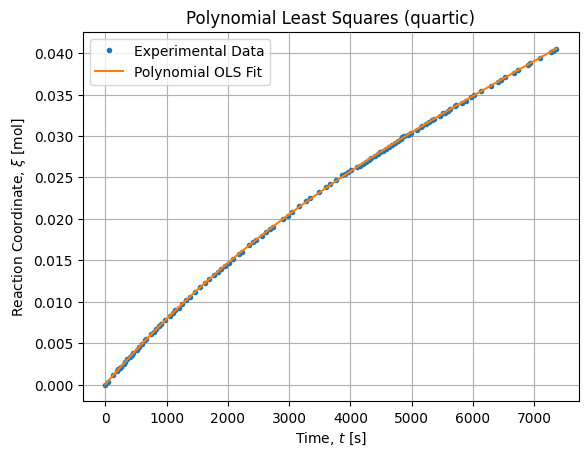

In [38]:
fig, axe = plt.subplots()
axe.plot(df["t"], df["xi"], ".", label="Experimental Data")
axe.plot(XP3, yP3hat, "-", label="Polynomial OLS Fit")
axe.set_title("Polynomial Least Squares (quartic)")
axe.set_xlabel("Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Reaction Coordinate, $\xi$ $[\mathrm{mol}]$")
axe.legend()
axe.grid()

In [39]:
XLBP3 = df["B/A"].values[1:].reshape(-1, 1)
yLBP3 = 1/dCdt
LBP3 = LinearRegression(fit_intercept=True).fit(XLBP3, yLBP3)
LBP3.score(XLBP3, yLBP3)

0.9930182093647469

In [40]:
yLBP3hat = LBP3.predict(XLBP3)

In [41]:
k1LBP3 = 1/LBP3.intercept_
k2LBP3 = LBP3.coef_[0]*k1LBP3
k1LBP3, k2LBP3

(0.0470140347134837, 75.45718580738553)

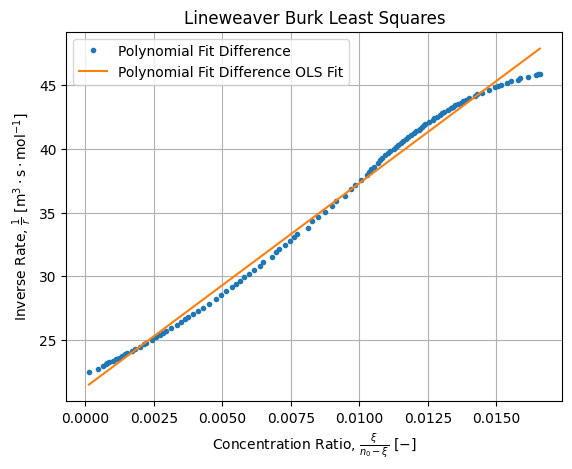

In [42]:
fig, axe = plt.subplots()
axe.plot(XLBP3, yLBP3, ".", label="Polynomial Fit Difference")
axe.plot(XLBP3, yLBP3hat, label="Polynomial Fit Difference OLS Fit")
#ylim = axe.get_ylim()
#axe.plot(df["B/A"], df["1/r1"], ".", color="lightgray", label="First Difference")
#axe.plot(XLB, yLBhat, color="gray", label="First Difference OLS Fit")
#axe.set_ylim(ylim)
axe.set_title("Lineweaver Burk Least Squares")
axe.set_xlabel(r"Concentration Ratio, $\frac{\xi}{n_0 - \xi}$ $[-]$")
axe.set_ylabel(r"Inverse Rate, $\frac{1}{r}$ $[\mathrm{m^3\cdot s \cdot mol^{-1}]}$")
axe.legend()
axe.grid()

In [43]:
results["LBP3"] = {
    "k1": k1LBP3, "k2": k2LBP3,
    "MSE": metrics.mean_squared_error(yLBP3, yLBP3hat),
    "r2": metrics.r2_score(yLBP3, yLBP3hat)
}
results["LBP3"]

{'k1': 0.0470140347134837,
 'k2': 75.45718580738553,
 'MSE': 0.4233812101229228,
 'r2': 0.9930182093647469}

# Smooth

In [44]:
r = df[["t", "xi"]].set_index('t')
r = r.reindex(range(r.index.max() + 1)).interpolate()
r["xis"] = signal.savgol_filter(r["xi"], 181, 5)
df["xis"] = r.loc[df["t"],"xis"].values

In [45]:
XLBS = df["B/A"].values[1:].reshape(-1, 1)
yLBS = V*np.diff(df["t"])/np.diff(df["xis"])
LBS = LinearRegression(fit_intercept=True).fit(XLBS, yLBS)
LBS.score(XLBP3, yLBP3)

0.9920825315351104

In [46]:
yLBShat = LBS.predict(XLBS)

In [47]:
k1LBS= 1/LBS.intercept_
k2LBS= LBS.coef_[0]*k1LBS
k1LBS, k2LBP3

(0.04700848211986167, 75.45718580738553)

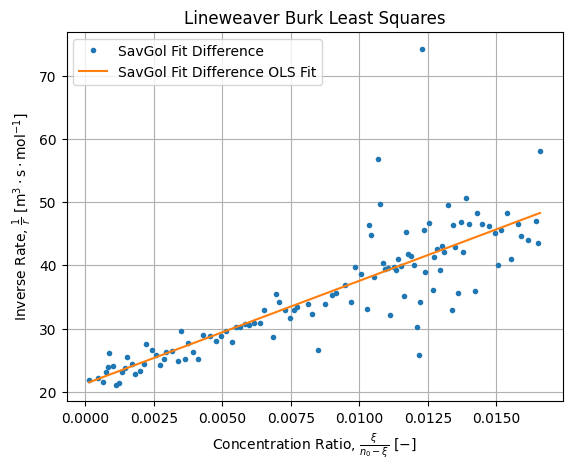

In [48]:
fig, axe = plt.subplots()
axe.plot(XLBS, yLBS, ".", label="SavGol Fit Difference")
axe.plot(XLBS, yLBShat, label="SavGol Fit Difference OLS Fit")
axe.set_title("Lineweaver Burk Least Squares")
axe.set_xlabel(r"Concentration Ratio, $\frac{\xi}{n_0 - \xi}$ $[-]$")
axe.set_ylabel(r"Inverse Rate, $\frac{1}{r}$ $[\mathrm{m^3\cdot s \cdot mol^{-1}]}$")
axe.legend()
axe.grid()

In [49]:
results["LBS"] = {
    "k1": k1LBS, "k2": k2LBS,
    "MSE": metrics.mean_squared_error(yLBS, yLBShat),
    "r2": metrics.r2_score(yLBS, yLBShat)
}
results["LBS"]

{'k1': 0.04700848211986167,
 'k2': 76.56199969884788,
 'MSE': 26.592136966726322,
 'r2': 0.6998645254963014}

# LBMan

In [50]:
df2 = pd.read_excel("cathet.xlsx", sheet_name="Manual")
df2["keep"] = True

In [51]:
df2["1/v"] *= V

In [52]:
df2.loc[0, "1/v"] = 22.45
df2.loc[4, "1/v"] = 32.45

In [53]:
df2.loc[0, "keep"] = False
df2.loc[4, "keep"] = False

In [54]:
#df2 = df2[df2["keep"]]
#df2

In [55]:
df2["1/v"] *= 1.1

In [56]:
XLBM = df2["bP/bR"].values[:-1].reshape(-1, 1)
yLBM = df2["1/v"].values[:-1]
LBM = LinearRegression(fit_intercept=True).fit(XLBM, yLBM)
LBM.score(XLBM, yLBM)

0.984458468896565

In [57]:
yLBMhat = LBM.predict(XLBM)

In [58]:
k1LBM = 1/LBM.intercept_
k2LBM = LBM.coef_[0]*k1LBM
k1LBM, k2LBM

(0.047296065060717624, 73.76063697071173)

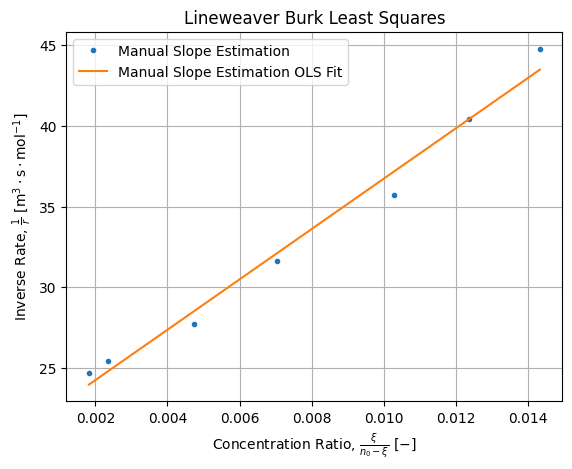

In [59]:
fig, axe = plt.subplots()
axe.plot(XLBM, yLBM, ".", label="Manual Slope Estimation")
axe.plot(XLBM, yLBMhat, label="Manual Slope Estimation OLS Fit")
axe.set_title("Lineweaver Burk Least Squares")
axe.set_xlabel(r"Concentration Ratio, $\frac{\xi}{n_0 - \xi}$ $[-]$")
axe.set_ylabel(r"Inverse Rate, $\frac{1}{r}$ $[\mathrm{m^3\cdot s \cdot mol^{-1}]}$")
axe.legend()
axe.grid()

In [60]:
results["LBM"] = {
    "k1": k1LBM, "k2": k2LBM,
    "MSE": metrics.mean_squared_error(yLBM, yLBMhat),
    "r2": metrics.r2_score(yLBM, yLBMhat)
}
results["LBM"]

{'k1': 0.047296065060717624,
 'k2': 73.76063697071173,
 'MSE': 0.7926235236812226,
 'r2': 0.984458468896565}

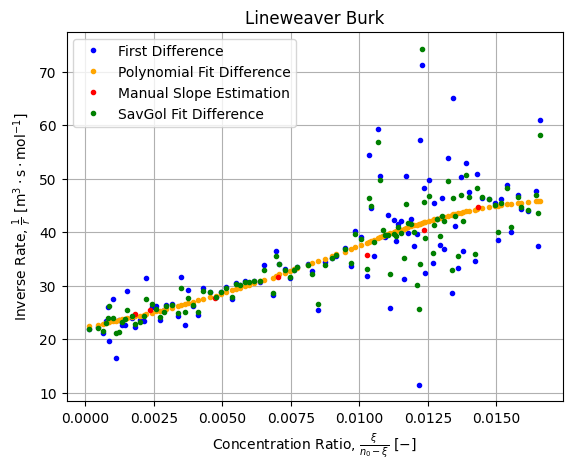

In [61]:
fig, axe = plt.subplots()
axe.plot(df["B/A"], df["1/r1"], ".", color="blue", label="First Difference")
#axe.plot(XLB, yLBhat, color="blue", label="First Difference OLS Fit")
axe.plot(XLBP3, yLBP3, ".", color="orange", label="Polynomial Fit Difference")
#axe.plot(XLBP3, yLBP3hat, color="darkorange", label="Polynomial Fit Difference OLS Fit")
axe.plot(XLBM, yLBM, ".", color="red", label="Manual Slope Estimation")
#axe.plot(XLBM, yLBMhat, color="green", label="Manual Slope Estimation OLS Fit")
axe.plot(XLBS, yLBS, ".", color="green", label="SavGol Fit Difference")
#axe.set_ylim([20, 50])
axe.set_title("Lineweaver Burk")
axe.set_xlabel(r"Concentration Ratio, $\frac{\xi}{n_0 - \xi}$ $[-]$")
axe.set_ylabel(r"Inverse Rate, $\frac{1}{r}$ $[\mathrm{m^3\cdot s \cdot mol^{-1}]}$")
axe.legend() # bbox_to_anchor=(1,1))
axe.grid()

## Analysis

In [62]:
final = pd.DataFrame(results).T
final

,k1,k2,MSE,r2
OLS,0.047536,78.005591,220.707334,0.999953
LB,0.047019,78.245130,49.817143,0.565121
LMA,0.047536,78.005590,220.707334,0.999953
LBP3,0.047014,75.457186,0.423381,0.993018
LBS,0.047008,76.562000,26.592137,0.699865
LBM,0.047296,73.760637,0.792624,0.984458


In [63]:
def regmse(x):
    that = objective(df["xi"], x["k1"], x["k2"])
    mse = metrics.mean_squared_error(df["t"], that)
    score = metrics.r2_score(df["t"], that)
    return pd.Series({"Fit MSE": mse, "Fit Score": score})

In [64]:
final = pd.concat([final, final.apply(regmse, axis=1)], axis=1)

In [65]:
final

,k1,k2,MSE,r2,Fit MSE,Fit Score
OLS,0.047536,78.005591,220.707334,0.999953,220.707334,0.999953
LB,0.047019,78.245130,49.817143,0.565121,2554.580075,0.999452
LMA,0.047536,78.005590,220.707334,0.999953,220.707334,0.999953
LBP3,0.047014,75.457186,0.423381,0.993018,265.317843,0.999943
LBS,0.047008,76.562000,26.592137,0.699865,641.381454,0.999862
LBM,0.047296,73.760637,0.792624,0.984458,3083.989339,0.999338


In [66]:
#print(final[["k1", "k2", "Fit MSE", "Fit Score"]].to_html())

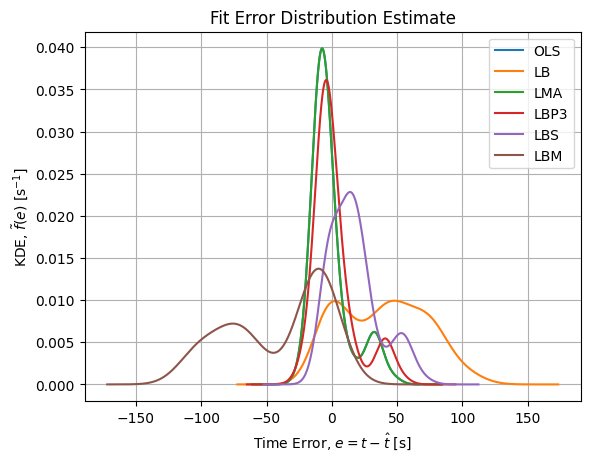

In [67]:
fig, axe = plt.subplots()
for x in final.reset_index().to_dict(orient="records"):
    that = objective(df["xi"], x["k1"], x["k2"])
    (that - df["t"]).plot(kind="kde", ax=axe, label=x["index"])
    df[x["index"]] = that
axe.set_title("Fit Error Distribution Estimate")
axe.set_xlabel(r"Time Error, $e = t - \hat{t}$ $[\mathrm{s}]$")
axe.set_ylabel(r"KDE, $\tilde{f}(e)$ $[\mathrm{s^{-1}}]$")
axe.legend()
axe.grid()

In [68]:
def factory(xs, ys):
    @np.vectorize
    def wrapper(k1, k2):
        that = objective(xs, k1, k2)
        mse = metrics.mean_squared_error(ys, that)
        return mse
    return wrapper

In [69]:
scoring = factory(df["xi"], df["t"])

In [80]:
k1l = np.linspace(4.0e-2, 5.5e-2, 150)
k2l = np.linspace(70, 90, 150)

In [81]:
K1, K2 = np.meshgrid(k1l, k2l)

In [82]:
MSE = scoring(K1, K2)

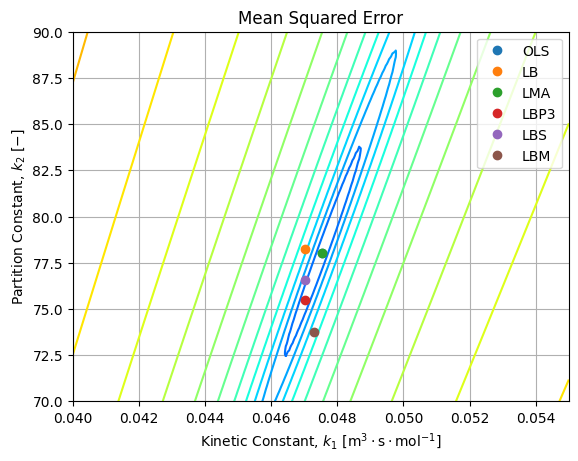

In [83]:
fig, axe = plt.subplots()
axe.contour(K1, K2, np.log10(MSE), np.arange(1, 8, 0.33), cmap="jet")
for exp in final.reset_index().to_dict(orient="records"):
    axe.plot(exp["k1"], exp["k2"], ".", markersize=12, label=exp["index"])
#axe.set_xscale("log")
#axe.set_yscale("log")
axe.set_title("Mean Squared Error")
axe.set_xlabel(r"Kinetic Constant, $k_1$ $[\mathrm{m^3\cdot s \cdot mol^{-1}]}$")
axe.set_ylabel(r"Partition Constant, $k_2$ $[-]$")
axe.legend(bbox_to_anchor=(1, 1))
axe.grid()

In [84]:
df

,t,V,xi,B/A,x1,x2,dxidt1,1/r1,xis,OLS,LB,LMA,LBP3,LBS,LBM
2,0,0.000000,0.000000,0.000000,0.000000,-0.000000,NaN,NaN,5.091380e-07,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
3,39,0.000008,0.000339,0.000137,1.783749,1.783871,0.000009,21.864063,3.384943e-04,37.724000,38.139834,37.724000,38.136279,38.143647,37.904500
4,131,0.000027,0.001126,0.000454,5.923808,5.925152,0.000009,22.221904,1.128021e-03,126.822127,128.224854,126.822128,128.157506,128.204224,127.345092
5,184,0.000038,0.001603,0.000646,8.434270,8.436994,0.000009,21.111656,1.596956e-03,181.899364,183.915338,181.899365,183.771477,183.857212,182.577910
6,214,0.000044,0.001845,0.000744,9.711522,9.715134,0.000008,23.487920,1.844197e-03,210.225391,212.557661,210.225392,212.363907,212.473885,210.967993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,6938,0.000927,0.038791,0.015879,204.162179,205.774609,0.000004,44.353932,3.879075e-02,6940.848897,7025.458676,6940.848890,6930.517037,6969.231684,6831.350617
114,7088,0.000943,0.039439,0.016149,207.575526,209.242616,0.000004,43.945140,3.943753e-02,7102.351334,7189.017179,7102.351327,7090.849877,7130.868124,6988.766652
115,7272,0.000960,0.040172,0.016453,211.429304,213.159215,0.000004,47.745348,4.018077e-02,7286.509361,7375.522204,7286.509353,7273.647557,7315.163837,7168.220862
116,7300,0.000964,0.040314,0.016513,212.178039,213.920291,0.000005,37.396452,4.030296e-02,7322.512252,7411.984239,7322.512244,7309.381248,7351.191803,7203.298773


<AxesSubplot:ylabel='Density'>

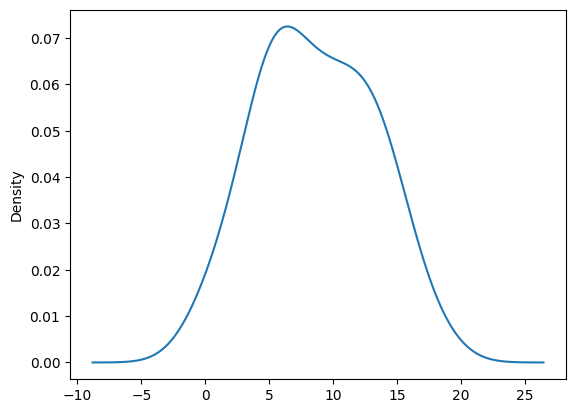

In [75]:
sample = df[df["t"]<1500]
(sample["t"] - sample["LMA"]).plot(kind="kde")